Total windows: 518 Feature dimension: 45
Class counts: {np.str_('circle'): np.int64(106), np.str_('handShaking'): np.int64(100), np.str_('turnover'): np.int64(99), np.str_('updown'): np.int64(104), np.str_('walking'): np.int64(109)}
Split sizes: 310 104 104
Best max_depth (by val log loss): 1

=== Test Metrics (Macro Avg) ===
Accuracy : 0.41346153846153844
Precision: 0.25121951219512195
Recall   : 0.4
F1-score : 0.2815533980582524
Log Loss : 1.1229353626219387

Confusion matrix (rows=true, cols=pred), labels = [np.str_('circle'), np.str_('handShaking'), np.str_('turnover'), np.str_('updown'), np.str_('walking')]
[[21  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]
 [21  0  0  0  0]
 [ 0  0  0  0 22]]


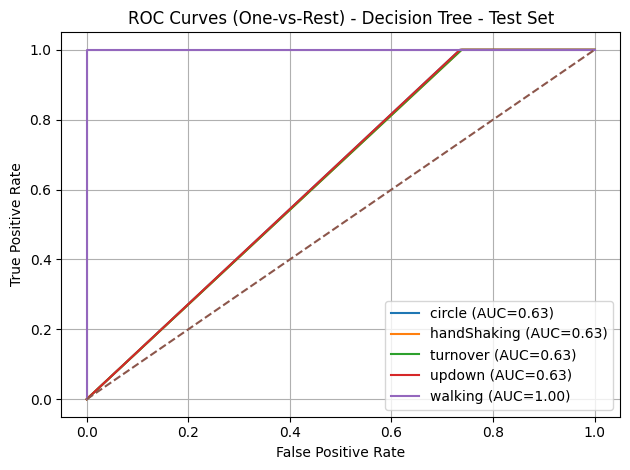

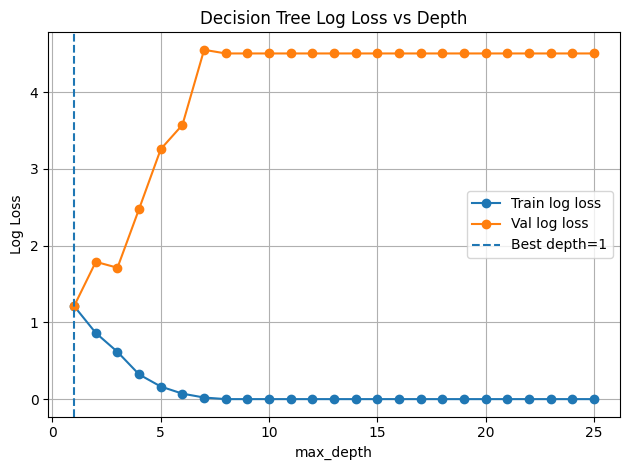

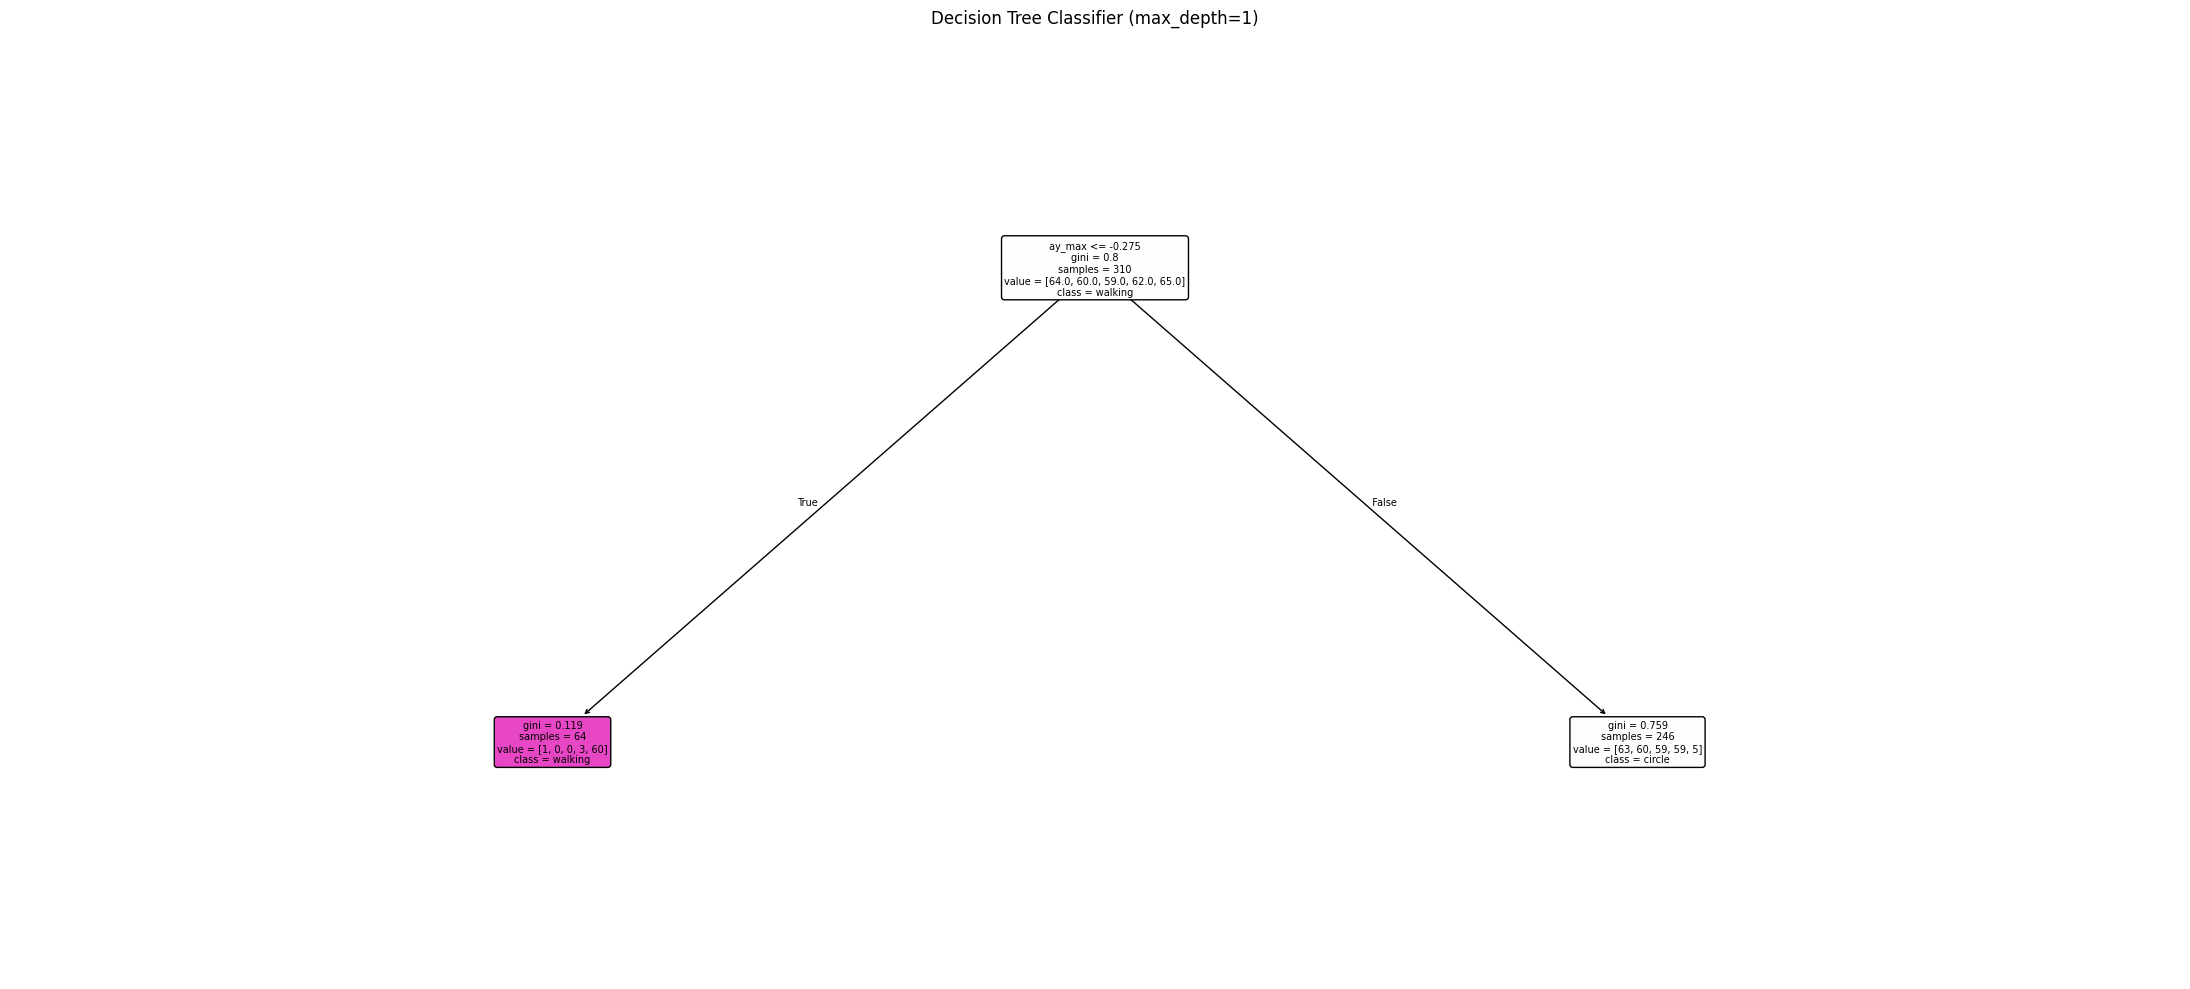


Saved figures:
  roc_auc_dt_test.png
  logloss_dt_vs_depth.png
  decision_tree_dt.png


In [1]:
# ----------------------------
# Decision Tree
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score,
    confusion_matrix, roc_curve, auc, log_loss
)
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1) File paths for 5 classes
# ----------------------------
paths = {
    "circle":        "imu_smooth_circle.csv",
    "handShaking":     "imu_smooth_handShaking.csv",
    "turnover":      "imu_smooth_turnover.csv",
    "updown":     "imu_smooth_updown.csv",
    "walking":  "imu_smooth_walking.csv",
}

# CSVs have no header row; enforce column names:
colnames = ["timestamp","ax","ay","az","gx","gy","gz","roll","pitch","yaw"]
channels = ["ax","ay","az","gx","gy","gz","roll","pitch","yaw"]

dfs = {label: pd.read_csv(p, header=None, names=colnames) for label, p in paths.items()}

# ----------------------------
# 2) Windowing (100 Hz IMU)
# ----------------------------
FS = 100
WIN = 100      # 1 second window
STRIDE = 50    # 0.5 second overlap

def window_featurize(df, label, win=WIN, stride=STRIDE):
    """
    Convert a time-series file into windowed feature vectors.
    Features per channel: mean, std, min, max, mean-square (energy proxy)
    """
    X, y = [], []
    for start in range(0, len(df) - win + 1, stride):
        w = df.iloc[start:start+win]
        feats = []
        for c in channels:
            x = w[c].astype(float).to_numpy()
            feats.extend([
                x.mean(),
                x.std(ddof=0),
                x.min(),
                x.max(),
                np.mean(x**2)
            ])
        X.append(feats)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y)

X_list, y_list = [], []
for label, df in dfs.items():
    Xw, yw = window_featurize(df, label)
    X_list.append(Xw)
    y_list.append(yw)

X = np.vstack(X_list)
y = np.concatenate(y_list)

feature_names = [f"{c}_{stat}" for c in channels for stat in ["mean","std","min","max","msq"]]

print("Total windows:", X.shape[0], "Feature dimension:", X.shape[1])
print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))

# ----------------------------
# 3) Split 60/20/20
# ----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Split sizes:", len(y_train), len(y_val), len(y_test))

# ----------------------------
# 4) Tune max_depth by validation log-loss
# ----------------------------
depths = list(range(1, 26))
train_ll, val_ll = [], []

for d in depths:
    clf_d = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf_d.fit(X_train, y_train)
    train_ll.append(log_loss(y_train, clf_d.predict_proba(X_train), labels=clf_d.classes_))
    val_ll.append(log_loss(y_val, clf_d.predict_proba(X_val), labels=clf_d.classes_))

best_depth = depths[int(np.argmin(val_ll))]
print("Best max_depth (by val log loss):", best_depth)

clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
clf.fit(X_train, y_train)

# ----------------------------
# 5) Test metrics
# ----------------------------
y_pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)
labels = list(clf.classes_)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
ll   = log_loss(y_test, proba, labels=labels)

print("\n=== Test Metrics (Macro Avg) ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("Log Loss :", ll)

cm = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion matrix (rows=true, cols=pred), labels =", labels)
print(cm)

# ----------------------------
# 6) Save visuals (must include '_dt_')
# ----------------------------
out_dir = ""
roc_path  = os.path.join(out_dir, "roc_auc_dt_test.png")
ll_path   = os.path.join(out_dir, "logloss_dt_vs_depth.png")
tree_path = os.path.join(out_dir, "decision_tree_dt.png")

# ROC-AUC curves (multiclass one-vs-rest)
y_test_bin = label_binarize(y_test, classes=labels)

plt.figure()
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - Decision Tree - Test Set")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(roc_path, dpi=200)
plt.show()

# Log loss vs depth curve (train vs val)
plt.figure()
plt.plot(depths, train_ll, marker="o", label="Train log loss")
plt.plot(depths, val_ll, marker="o", label="Val log loss")
plt.axvline(best_depth, linestyle="--", label=f"Best depth={best_depth}")
plt.xlabel("max_depth")
plt.ylabel("Log Loss")
plt.title("Decision Tree Log Loss vs Depth")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(ll_path, dpi=200)
plt.show()

# Decision Tree visualization
plt.figure(figsize=(22, 10))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=labels,
    filled=True,
    rounded=True,
    fontsize=7,
    max_depth=min(best_depth, 4)   # display only top levels so it stays readable
)
plt.title(f"Decision Tree Classifier (max_depth={best_depth})")
plt.tight_layout()
plt.savefig(tree_path, dpi=200)
plt.show()

print("\nSaved figures:")
print(" ", roc_path)
print(" ", ll_path)
print(" ", tree_path)


Evaluation Metrics (Test Set):
Accuracy: 0.9960
Precision: 0.9960
Recall: 0.9960
F1 Score: 0.9960


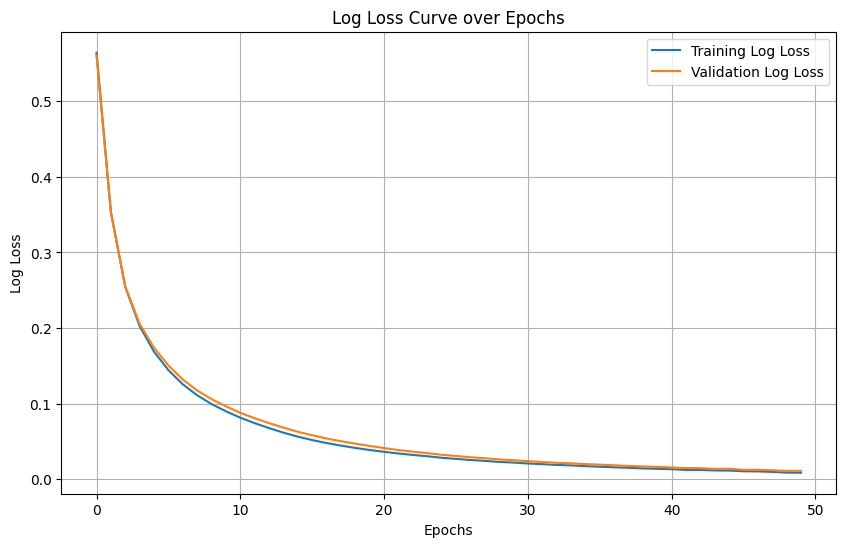

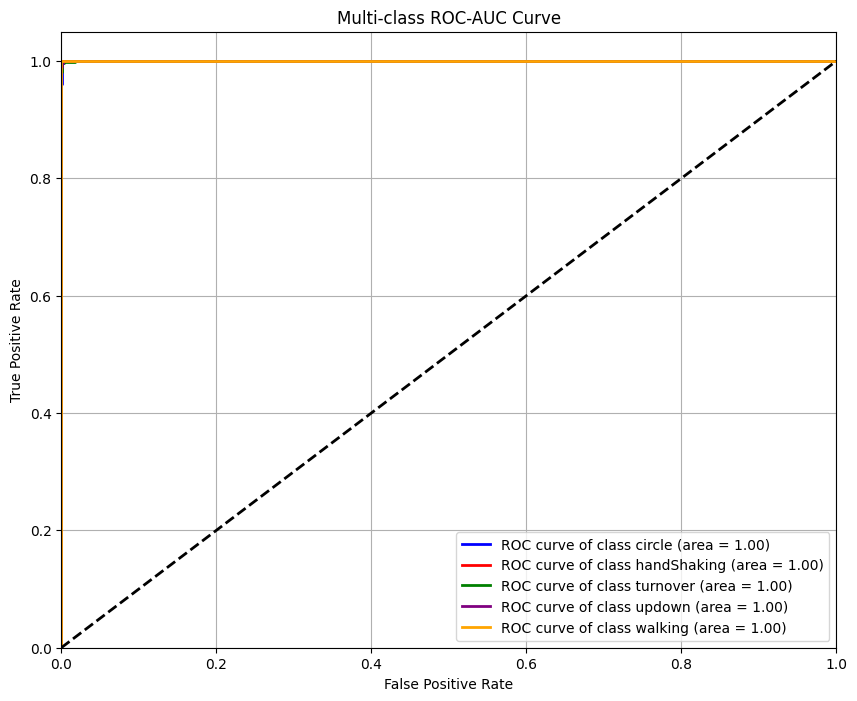

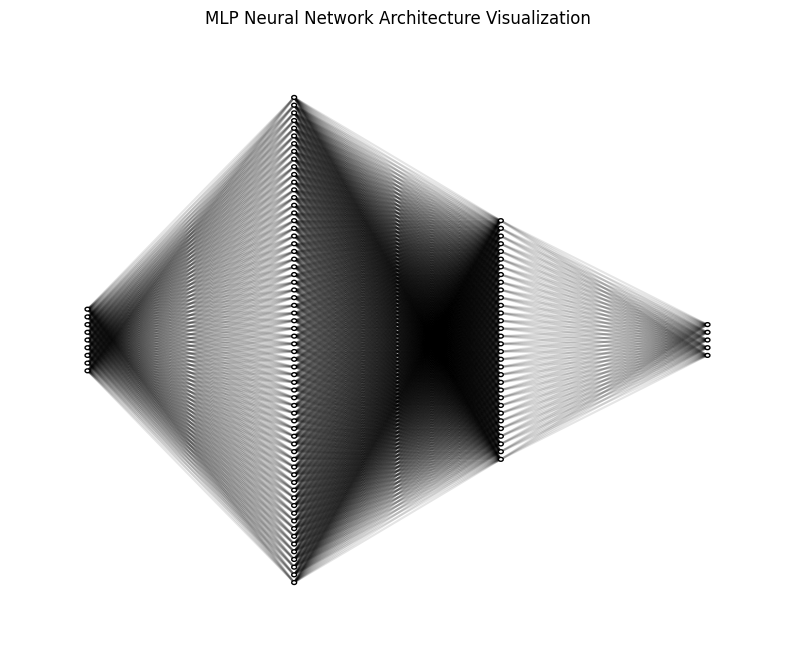

In [4]:
# ----------------------------
# MLP
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, auc

# 1. Load Data
# Define file paths and class names
files = {
    "circle":        "imu_smooth_circle.csv",
    "handShaking":     "imu_smooth_handShaking.csv",
    "turnover":      "imu_smooth_turnover.csv",
    "updown":     "imu_smooth_updown.csv",
    "walking":  "imu_smooth_walking.csv",
}
cols = ['timestamp', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'roll', 'pitch', 'yaw']

# Load and label datasets
data_list = []
class_names = ['circle', 'handShaking', 'turnover', 'updown', 'walking']

for i, class_name in enumerate(class_names):
    df = pd.read_csv(files[class_name], header=None, names=cols)
    df['label'] = i  # Assign numeric label 0-4
    data_list.append(df)

# Concatenate into a single dataframe
full_data = pd.concat(data_list, ignore_index=True)

# 2. Preprocessing
# Separate features (X) and target (y)
# Exclude 'timestamp' (col 0) and 'label' (last col) from features
X = full_data.iloc[:, 1:-1].values
y = full_data['label'].values

# Split Data: 60% Train, 20% Validation, 20% Test
# First, split into 80% (Train+Val) and 20% (Test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Second, split the 80% (Train+Val) into 75% Train (which is 60% of total) and 25% Val (which is 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. Model Training
# Initialize MLP Classifier
# max_iter=1 and warm_start=True allow us to loop manually to record log loss history
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                    alpha=0.0001, batch_size=64, learning_rate_init=0.001,
                    random_state=42, warm_start=True, max_iter=1)

train_loss_history = []
val_loss_history = []
epochs = 50
unique_classes = np.unique(y)

# Manual training loop to capture loss per epoch
for epoch in range(epochs):
    mlp.partial_fit(X_train_scaled, y_train, classes=unique_classes)

    # Calculate Log Loss for learning curves
    y_train_prob = mlp.predict_proba(X_train_scaled)
    y_val_prob = mlp.predict_proba(X_val_scaled)

    train_loss_history.append(log_loss(y_train, y_train_prob))
    val_loss_history.append(log_loss(y_val, y_val_prob))

# 4. Evaluation Metrics
y_test_pred = mlp.predict(X_test_scaled)
y_test_prob = mlp.predict_proba(X_test_scaled)

print("Evaluation Metrics (Test Set):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

# 5. Visualizations

# --- Plot 1: Log Loss Curve ---
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Log Loss')
plt.plot(val_loss_history, label='Validation Log Loss')
plt.title('Log Loss Curve over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.savefig('log_loss_curve_mlp.png')
plt.show()

# --- Plot 2: ROC-AUC Curve ---
# Binarize labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC per class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC-AUC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_auc_curve_mlp.png')
plt.show()


# --- Plot 3: MLP Architecture Visualization ---
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Helper function to draw a neural network graph
    '''
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size):
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), v_spacing / 4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n * h_spacing + left, (n + 1) * h_spacing + left],
                                  [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing], c='k', alpha=0.1)
                ax.add_artist(line)


fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.axis('off')
# Visualize architecture: Input(9) -> Hidden(64) -> Hidden(32) -> Output(5)
draw_neural_net(ax, .1, .9, .1, .9, [9, 64, 32, 5])
plt.title('MLP Neural Network Architecture Visualization')
plt.savefig('architecture_visualization_mlp.png')
plt.show()

Total windows: 518 Feature dim: 45
Class counts: {np.str_('circle'): np.int64(106), np.str_('handShaking'): np.int64(100), np.str_('turnover'): np.int64(99), np.str_('updown'): np.int64(104), np.str_('walking'): np.int64(109)}
Stopped at epoch=120; best epoch=116, best val logloss=0.2042

=== Test Metrics (Macro Avg) ===
Accuracy : 0.9423076923076923
Precision: 0.9488095238095239
Recall   : 0.9414285714285715
F1-score : 0.9414921341114342

Confusion matrix (rows=true, cols=pred):
                  pred_circle  pred_handShaking  pred_turnover  pred_updown  \
true_circle                18                 1              0            1   
true_handShaking            0                20              0            0   
true_turnover               0                 0             17            2   
true_updown                 0                 0              0           21   
true_walking                0                 0              0            0   

                  pred_walking  
true_ci

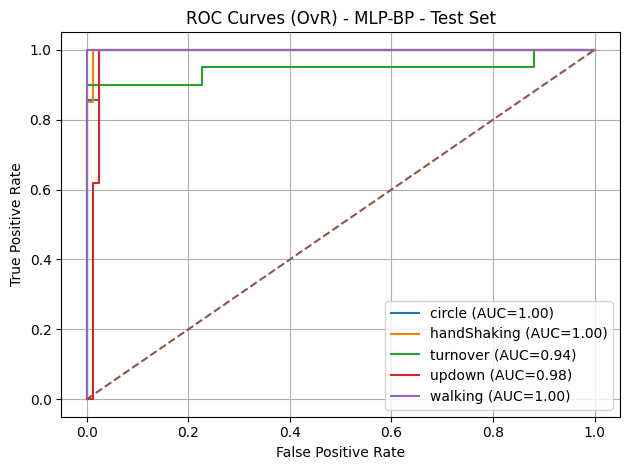

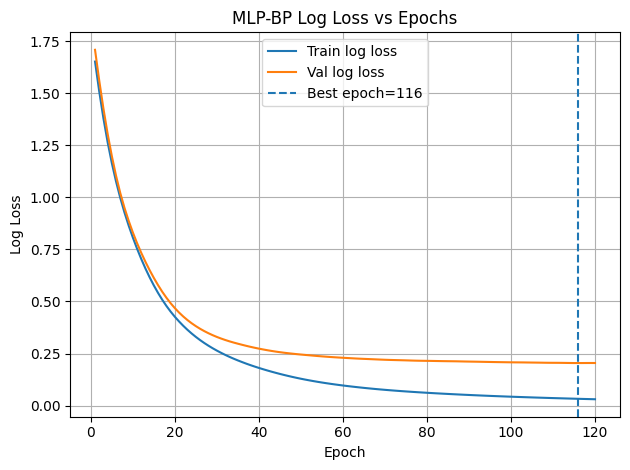

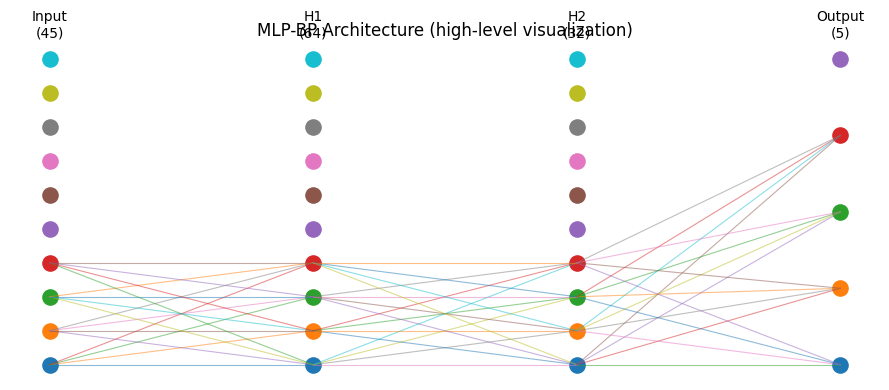

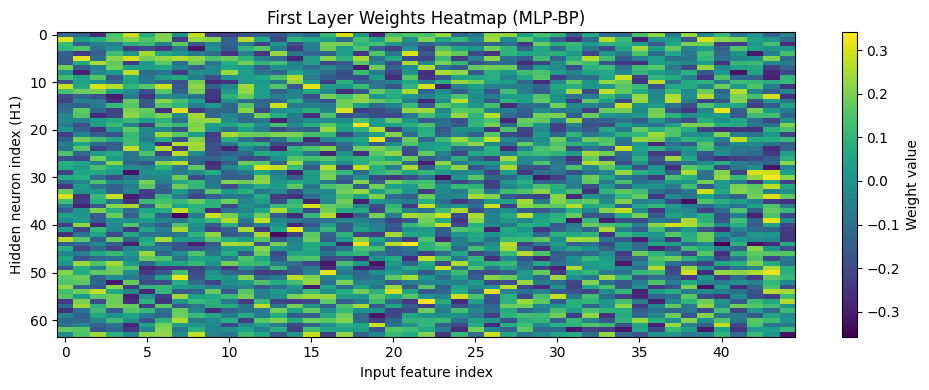


Saved figures:
  roc_auc_mlpBP_test.png
  logloss_mlpBP_epochs.png
  mlpBP_architecture_mlpBP.png
  first_layer_weights_mlpBP.png


In [5]:
# ----------------------------
# MLP BP
# ----------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, log_loss
)

# ---------------------------------------------------------
# 1) Load your 5 class CSVs (NO headers assumed)
# ---------------------------------------------------------
paths = {
    "circle":        "imu_smooth_circle.csv",
    "handShaking":     "imu_smooth_handShaking.csv",
    "turnover":      "imu_smooth_turnover.csv",
    "updown":     "imu_smooth_updown.csv",
    "walking":  "imu_smooth_walking.csv",
}

colnames  = ["timestamp","ax","ay","az","gx","gy","gz","roll","pitch","yaw"]
channels  = ["ax","ay","az","gx","gy","gz","roll","pitch","yaw"]

dfs = {label: pd.read_csv(p, header=None, names=colnames) for label, p in paths.items()}

# ---------------------------------------------------------
# 2) Windowed feature extraction (recommended for 100 Hz IMU)
# ---------------------------------------------------------
FS = 100
WIN = 100     # 1 second window
STRIDE = 50   # 0.5 sec overlap

def window_featurize(df, label, win=WIN, stride=STRIDE):
    """
    For each window, compute per-channel features:
    mean, std, min, max, mean-square (energy proxy)
    """
    X, y = [], []
    for start in range(0, len(df) - win + 1, stride):
        w = df.iloc[start:start+win]
        feats = []
        for c in channels:
            x = w[c].astype(float).to_numpy()
            feats.extend([x.mean(), x.std(ddof=0), x.min(), x.max(), np.mean(x**2)])
        X.append(feats)
        y.append(label)
    return np.asarray(X, dtype=np.float32), np.asarray(y)

X_list, y_list = [], []
for label, df in dfs.items():
    Xw, yw = window_featurize(df, label)
    X_list.append(Xw)
    y_list.append(yw)

X = np.vstack(X_list)
y = np.concatenate(y_list)

feature_names = [f"{c}_{stat}" for c in channels for stat in ["mean","std","min","max","msq"]]

print("Total windows:", X.shape[0], "Feature dim:", X.shape[1])
print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))

# ---------------------------------------------------------
# 3) Split 60% train, 20% val, 20% test (stratified)
# ---------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Encode labels to integers for ROC & log-loss tracking
le = LabelEncoder()
y_train_i = le.fit_transform(y_train)
y_val_i   = le.transform(y_val)
y_test_i  = le.transform(y_test)
class_names = le.classes_.tolist()
n_classes = len(class_names)

# Scale features (important for MLP)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# ---------------------------------------------------------
# 4) MLP + Backprop training (explicit epoch loop using partial_fit)
#    - This makes the "Log Loss vs Epochs" curve clear for students.
# ---------------------------------------------------------
# MLPClassifier uses backpropagation internally (gradient-based optimization).
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=1,         # one "epoch" per partial_fit call
    warm_start=True,
    random_state=42
)

EPOCHS = 120
PATIENCE = 12

train_ll, val_ll = [], []
best_val = float("inf")
best_epoch = 0
best_params = None
pat = 0

for epoch in range(1, EPOCHS + 1):
    # First call needs 'classes='
    if epoch == 1:
        mlp.partial_fit(X_train_s, y_train_i, classes=np.arange(n_classes))
    else:
        mlp.partial_fit(X_train_s, y_train_i)

    # Track log-loss on train/val
    p_tr = mlp.predict_proba(X_train_s)
    p_va = mlp.predict_proba(X_val_s)
    ll_tr = log_loss(y_train_i, p_tr, labels=np.arange(n_classes))
    ll_va = log_loss(y_val_i, p_va, labels=np.arange(n_classes))

    train_ll.append(ll_tr)
    val_ll.append(ll_va)

    # Early stopping
    if ll_va + 1e-6 < best_val:
        best_val = ll_va
        best_epoch = epoch
        best_params = mlp.coefs_, mlp.intercepts_
        pat = 0
    else:
        pat += 1
        if pat >= PATIENCE:
            break

# Restore best weights (so evaluation uses best validation point)
if best_params is not None:
    mlp.coefs_, mlp.intercepts_ = best_params

print(f"Stopped at epoch={len(train_ll)}; best epoch={best_epoch}, best val logloss={best_val:.4f}")

# ---------------------------------------------------------
# 5) Evaluate on test set: Precision/Recall/Accuracy/F1
# ---------------------------------------------------------
y_pred = mlp.predict(X_test_s)
p_test = mlp.predict_proba(X_test_s)

acc  = accuracy_score(y_test_i, y_pred)
prec = precision_score(y_test_i, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test_i, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test_i, y_pred, average="macro", zero_division=0)
cm   = confusion_matrix(y_test_i, y_pred)

print("\n=== Test Metrics (Macro Avg) ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                      columns=[f"pred_{c}" for c in class_names]))

# ---------------------------------------------------------
# 6) Save required visualizations with substring "_mlpBP_"
# ---------------------------------------------------------
out_dir = ""
roc_path  = os.path.join(out_dir, "roc_auc_mlpBP_test.png")
ll_path   = os.path.join(out_dir, "logloss_mlpBP_epochs.png")
arch_path = os.path.join(out_dir, "mlpBP_architecture_mlpBP.png")
w1_path   = os.path.join(out_dir, "first_layer_weights_mlpBP.png")

# (A) ROC-AUC (One-vs-Rest)
y_test_bin = label_binarize(y_test_i, classes=np.arange(n_classes))

plt.figure()
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], p_test[:, i])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OvR) - MLP-BP - Test Set")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(roc_path, dpi=200)
plt.show()

# (B) Log Loss vs Epochs
plt.figure()
plt.plot(range(1, len(train_ll)+1), train_ll, label="Train log loss")
plt.plot(range(1, len(val_ll)+1), val_ll, label="Val log loss")
plt.axvline(best_epoch, linestyle="--", label=f"Best epoch={best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("MLP-BP Log Loss vs Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(ll_path, dpi=200)
plt.show()

# (C) Model visualization: Architecture diagram (high-level)
# Show up to 10 nodes per layer for readability
input_dim = X.shape[1]
hidden = (64, 32)
output_dim = n_classes

plt.figure(figsize=(9, 4))
layers = [("Input", min(10, input_dim)),
          ("H1", min(10, hidden[0])),
          ("H2", min(10, hidden[1])),
          ("Output", output_dim)]
xpos = np.linspace(0.1, 0.9, len(layers))

for x, (lname, n) in zip(xpos, layers):
    ys = np.linspace(0.1, 0.9, n)
    for yv in ys:
        plt.scatter([x], [yv], s=120)
    shown = input_dim if lname == "Input" else (hidden[0] if lname=="H1" else (hidden[1] if lname=="H2" else output_dim))
    plt.text(x, 0.95, f"{lname}\n({shown})", ha="center", va="bottom")

for li in range(len(layers)-1):
    x1, x2 = xpos[li], xpos[li+1]
    y1s = np.linspace(0.1, 0.9, layers[li][1])
    y2s = np.linspace(0.1, 0.9, layers[li+1][1])
    for a in y1s[:min(4,len(y1s))]:
        for b in y2s[:min(4,len(y2s))]:
            plt.plot([x1, x2], [a, b], linewidth=0.8, alpha=0.5)

plt.axis("off")
plt.title("MLP-BP Architecture (high-level visualization)")
plt.tight_layout()
plt.savefig(arch_path, dpi=200)
plt.show()

# (D) Model-derived visualization: First-layer weight heatmap
# coefs_[0] has shape (input_dim, hidden1); transpose to (hidden1, input_dim)
W1 = mlp.coefs_[0].T
plt.figure(figsize=(10, 4))
plt.imshow(W1, aspect="auto")
plt.colorbar(label="Weight value")
plt.xlabel("Input feature index")
plt.ylabel("Hidden neuron index (H1)")
plt.title("First Layer Weights Heatmap (MLP-BP)")
plt.tight_layout()
plt.savefig(w1_path, dpi=200)
plt.show()

print("\nSaved figures:")
print(" ", roc_path)
print(" ", ll_path)
print(" ", arch_path)
print(" ", w1_path)

Total windows: 518 Feature dimension: 45
Class counts: {np.str_('circle'): np.int64(106), np.str_('handShaking'): np.int64(100), np.str_('turnover'): np.int64(99), np.str_('updown'): np.int64(104), np.str_('walking'): np.int64(109)}
Split sizes: 310 104 104

Top sweep results:
    n_estimators max_depth  val_log_loss
0           200         8      0.241103
1           200      None      0.241347
2           200        12      0.241347
3            50         8      0.242719
4           100         8      0.243882
5           100      None      0.245617
6           100        12      0.245617
7            50        12      0.252109
8            50      None      0.252109
9           100         5      0.283845

Best params: {'n_estimators': 200, 'max_depth': 8, 'val_log_loss': 0.24110269416810653}

=== Test Metrics (Macro Avg) ===
Accuracy : 0.9519230769230769
Precision: 0.9568181818181818
Recall   : 0.9514285714285714
F1-score : 0.951231925968768
Log Loss : 0.27447106606839206

Confusi

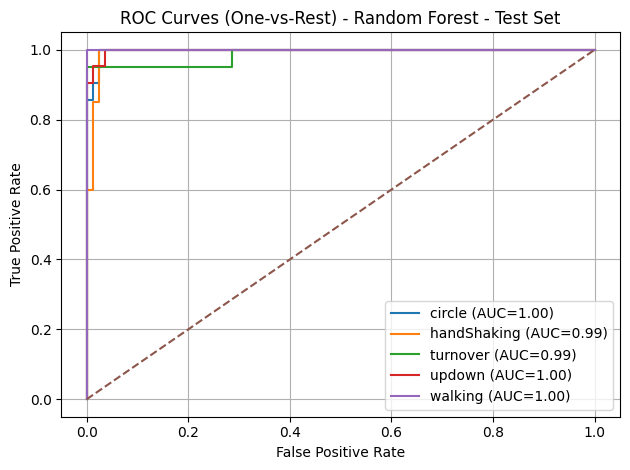

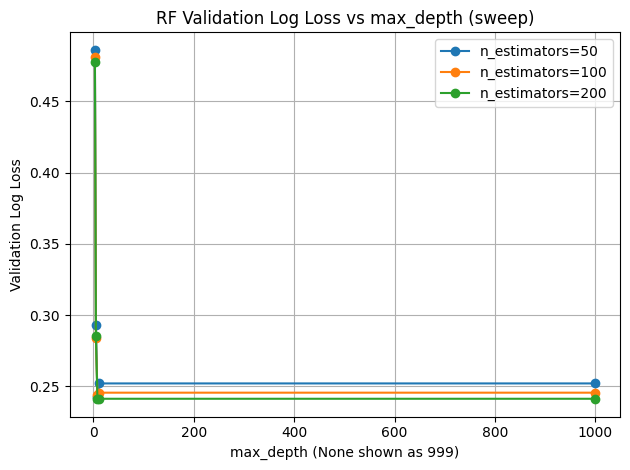

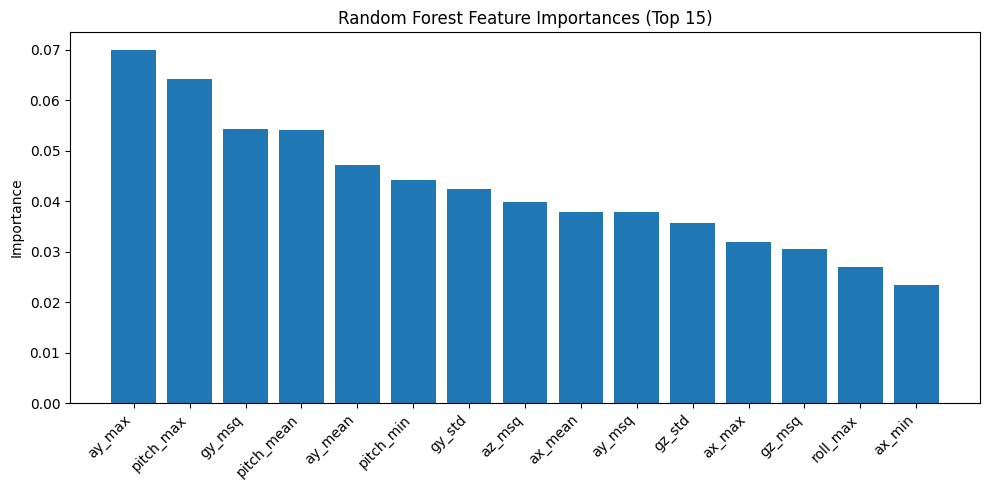

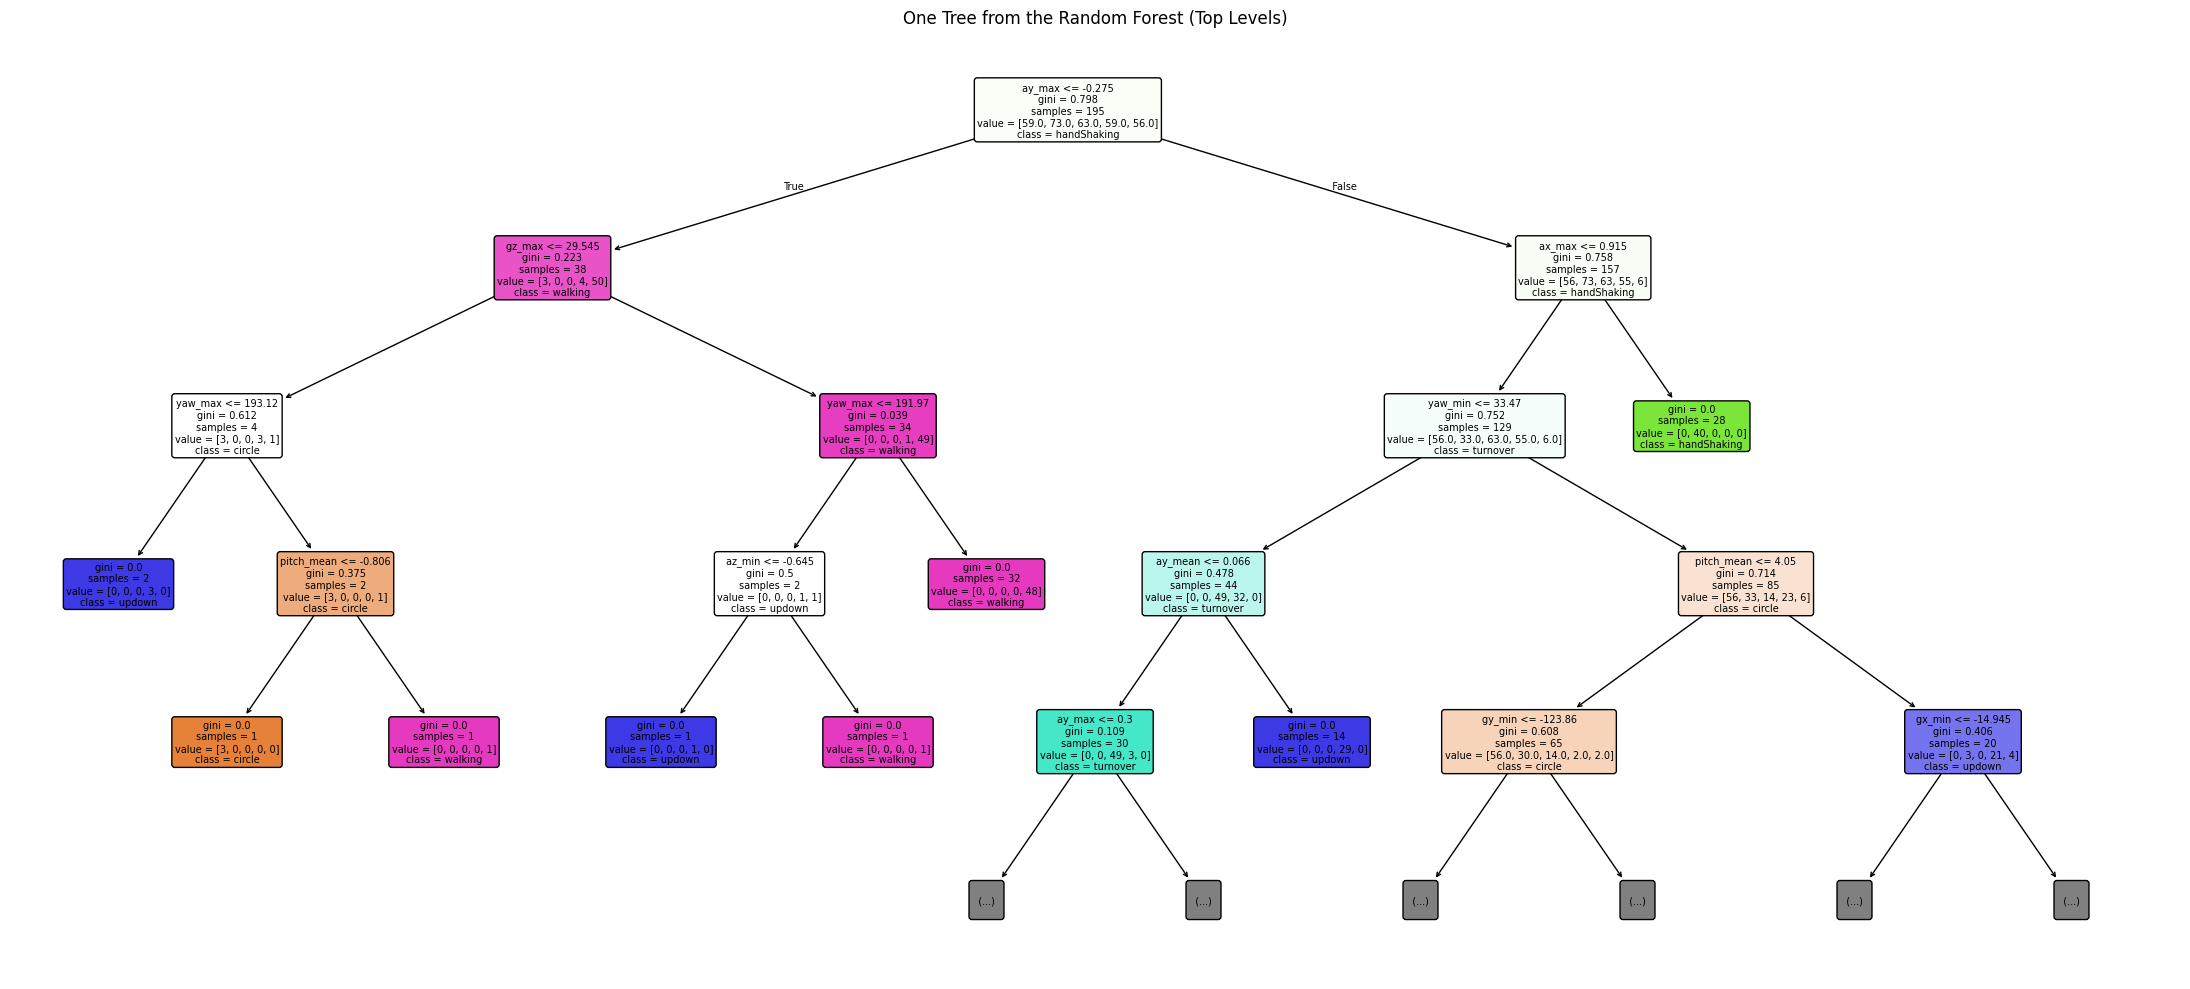


Saved figures:
  roc_auc_rf_test.png
  logloss_rf_sweep.png
  feature_importance_rf.png
  one_tree_rf.png


In [6]:
# ----------------------------
# random forest
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score,
    confusion_matrix, roc_curve, auc, log_loss
)
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1) File paths for 5 classes
# ----------------------------
paths = {
    "circle":        "imu_smooth_circle.csv",
    "handShaking":     "imu_smooth_handShaking.csv",
    "turnover":      "imu_smooth_turnover.csv",
    "updown":     "imu_smooth_updown.csv",
    "walking":  "imu_smooth_walking.csv",
}

# CSVs have no header row; enforce column names:
colnames = ["timestamp","ax","ay","az","gx","gy","gz","roll","pitch","yaw"]
channels = ["ax","ay","az","gx","gy","gz","roll","pitch","yaw"]

dfs = {label: pd.read_csv(p, header=None, names=colnames) for label, p in paths.items()}

# ----------------------------
# 2) Windowing (100 Hz IMU)
# ----------------------------
FS = 100
WIN = 100      # 1 second window
STRIDE = 50    # 0.5 second overlap

def window_featurize(df, label, win=WIN, stride=STRIDE):
    """
    Convert a time-series file into windowed feature vectors.
    Features per channel: mean, std, min, max, mean-square (energy proxy)
    """
    X, y = [], []
    for start in range(0, len(df) - win + 1, stride):
        w = df.iloc[start:start+win]
        feats = []
        for c in channels:
            x = w[c].astype(float).to_numpy()
            feats.extend([
                x.mean(),
                x.std(ddof=0),
                x.min(),
                x.max(),
                np.mean(x**2)
            ])
        X.append(feats)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y)

X_list, y_list = [], []
for label, df in dfs.items():
    Xw, yw = window_featurize(df, label)
    X_list.append(Xw)
    y_list.append(yw)

X = np.vstack(X_list)
y = np.concatenate(y_list)

feature_names = [f"{c}_{stat}" for c in channels for stat in ["mean","std","min","max","msq"]]

print("Total windows:", X.shape[0], "Feature dimension:", X.shape[1])
print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))

# ----------------------------
# 3) Split 60/20/20
# ----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Split sizes:", len(y_train), len(y_val), len(y_test))

# ----------------------------
# 4) Hyperparameter sweep (tune by validation log loss)
# ----------------------------
n_estimators_grid = [50, 100, 200]
max_depth_grid = [None, 3, 5, 8, 12]

best = None
records = []

for n_est in n_estimators_grid:
    for md in max_depth_grid:
        rf_try = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=md,
            random_state=42,
            n_jobs=-1
        )
        rf_try.fit(X_train, y_train)
        val_proba = rf_try.predict_proba(X_val)
        ll = log_loss(y_val, val_proba, labels=rf_try.classes_)

        records.append({"n_estimators": n_est, "max_depth": str(md), "val_log_loss": ll})
        if best is None or ll < best["val_log_loss"]:
            best = {"n_estimators": n_est, "max_depth": md, "val_log_loss": ll}

tune_df = pd.DataFrame(records).sort_values("val_log_loss").reset_index(drop=True)
print("\nTop sweep results:\n", tune_df.head(10))
print("\nBest params:", best)

# Train final RF
rf = RandomForestClassifier(
    n_estimators=best["n_estimators"],
    max_depth=best["max_depth"],
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ----------------------------
# 5) Test metrics
# ----------------------------
y_pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)
labels = list(rf.classes_)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
ll   = log_loss(y_test, proba, labels=labels)

print("\n=== Test Metrics (Macro Avg) ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("Log Loss :", ll)

cm = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion matrix (rows=true, cols=pred), labels =", labels)
print(cm)

# ----------------------------
# 6) Save visuals (must include '_rf_')
# ----------------------------
out_dir = ""
roc_path  = os.path.join(out_dir, "roc_auc_rf_test.png")
ll_path   = os.path.join(out_dir, "logloss_rf_sweep.png")
imp_path  = os.path.join(out_dir, "feature_importance_rf.png")
tree_path = os.path.join(out_dir, "one_tree_rf.png")

# ROC-AUC curves (multiclass one-vs-rest)
y_test_bin = label_binarize(y_test, classes=labels)

plt.figure()
for i, lab in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - Random Forest - Test Set")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(roc_path, dpi=200)
plt.show()

# Log loss curve for sweep results
plt.figure()
for n_est in n_estimators_grid:
    sub = tune_df[tune_df["n_estimators"] == n_est].copy()

    def md_to_num(v):
        return 999 if v == "None" else int(v)

    sub["md_num"] = sub["max_depth"].apply(md_to_num)
    sub = sub.sort_values("md_num")

    plt.plot(sub["md_num"], sub["val_log_loss"], marker="o", label=f"n_estimators={n_est}")

plt.xlabel("max_depth (None shown as 999)")
plt.ylabel("Validation Log Loss")
plt.title("RF Validation Log Loss vs max_depth (sweep)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(ll_path, dpi=200)
plt.show()

# Feature importances (Top 15)
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10, 5))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=45, ha="right")
plt.title("Random Forest Feature Importances (Top 15)")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig(imp_path, dpi=200)
plt.show()

# Visualize one representative tree (tree #0) from the forest
est0 = rf.estimators_[0]
plt.figure(figsize=(22, 10))
plot_tree(
    est0,
    feature_names=feature_names,
    class_names=labels,
    filled=True,
    rounded=True,
    fontsize=7,
    max_depth=4
)
plt.title("One Tree from the Random Forest (Top Levels)")
plt.tight_layout()
plt.savefig(tree_path, dpi=200)
plt.show()

print("\nSaved figures:")
print(" ", roc_path)
print(" ", ll_path)
print(" ", imp_path)
print(" ", tree_path)

Total windows: 518 Feature dimension: 45
Class counts: {np.str_('circle'): np.int64(106), np.str_('handShaking'): np.int64(100), np.str_('turnover'): np.int64(99), np.str_('updown'): np.int64(104), np.str_('walking'): np.int64(109)}
Split sizes: 310 104 104

Top sweep results:
        C  gamma  val_log_loss
0   10.0  scale      0.158748
1  100.0  scale      0.160791
2    1.0  scale      0.165848
3    1.0   0.01      0.179640
4  100.0   0.01      0.181090
5   10.0   0.01      0.187977
6   10.0    0.1      0.197703
7  100.0    0.1      0.197703
8    1.0    0.1      0.223007
9    0.1  scale      0.229536

Best params: {'C': 10, 'gamma': 'scale', 'val_log_loss': 0.1587484529221513}

=== Test Metrics (Macro Avg) ===
Accuracy : 0.9519230769230769
Precision: 0.958
Recall   : 0.950952380952381
F1-score : 0.9520823798627003
Log Loss : 0.17583548018460313

Confusion matrix (rows=true, cols=pred), labels = ['circle', 'handShaking', 'turnover', 'updown', 'walking']
[[19  1  0  1  0]
 [ 0 19  0  1 

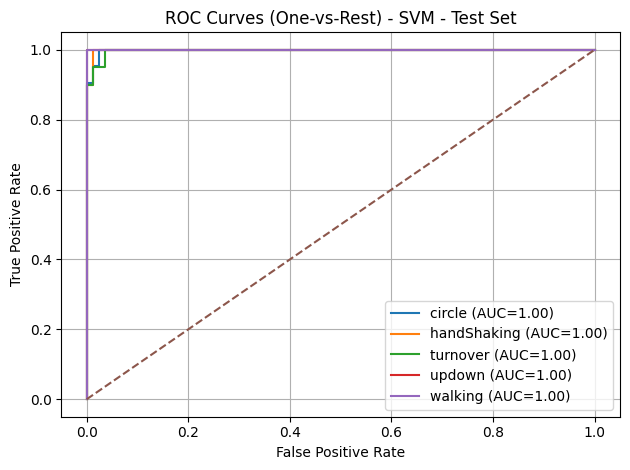

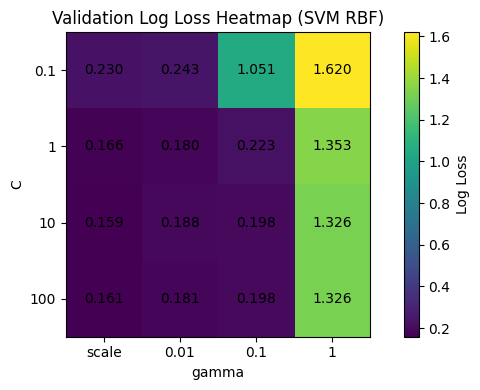

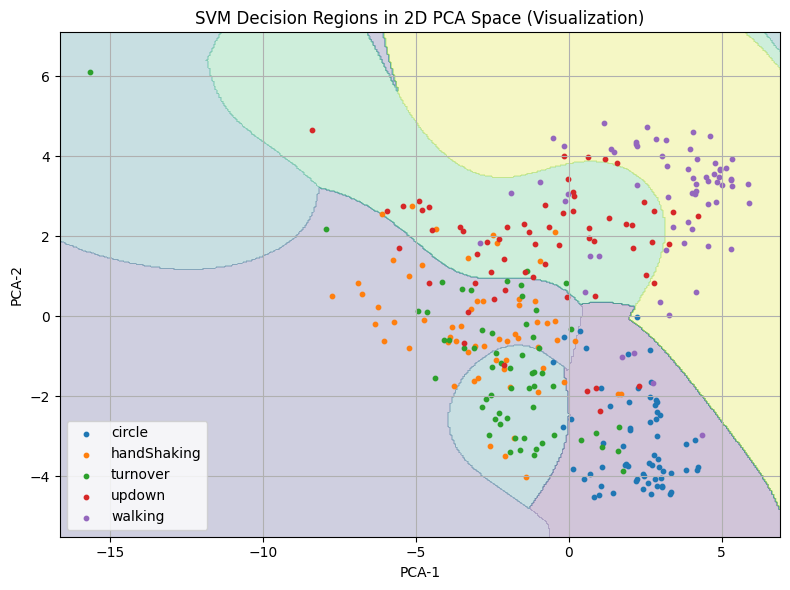


Saved figures:
  roc_auc_svm_test.png
  logloss_svm_heatmap.png
  decision_regions_svm_pca_svm.png


In [7]:
# ----------------------------
# SVM
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score,
    confusion_matrix, roc_curve, auc, log_loss
)

# ----------------------------
# 1) File paths for 5 classes
# ----------------------------
paths = {
    "circle":        "imu_smooth_circle.csv",
    "handShaking":     "imu_smooth_handShaking.csv",
    "turnover":      "imu_smooth_turnover.csv",
    "updown":     "imu_smooth_updown.csv",
    "walking":  "imu_smooth_walking.csv",
}

# CSVs have no header row; enforce column names:
colnames = ["timestamp","ax","ay","az","gx","gy","gz","roll","pitch","yaw"]
channels = ["ax","ay","az","gx","gy","gz","roll","pitch","yaw"]

dfs = {label: pd.read_csv(p, header=None, names=colnames) for label, p in paths.items()}

# ----------------------------
# 2) Windowing (100 Hz IMU)
# ----------------------------
FS = 100
WIN = 100      # 1 second window
STRIDE = 50    # 0.5 second overlap

def window_featurize(df, label, win=WIN, stride=STRIDE):
    """
    Convert a time-series file into windowed feature vectors.
    Features per channel: mean, std, min, max, mean-square (energy proxy)
    """
    X, y = [], []
    for start in range(0, len(df) - win + 1, stride):
        w = df.iloc[start:start+win]
        feats = []
        for c in channels:
            x = w[c].astype(float).to_numpy()
            feats.extend([
                x.mean(),
                x.std(ddof=0),
                x.min(),
                x.max(),
                np.mean(x**2)
            ])
        X.append(feats)
        y.append(label)
    return np.array(X, dtype=np.float32), np.array(y)

X_list, y_list = [], []
for label, df in dfs.items():
    Xw, yw = window_featurize(df, label)
    X_list.append(Xw)
    y_list.append(yw)

X = np.vstack(X_list)
y = np.concatenate(y_list)

print("Total windows:", X.shape[0], "Feature dimension:", X.shape[1])
print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))

# ----------------------------
# 3) Split 60/20/20
# ----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Split sizes:", len(y_train), len(y_val), len(y_test))

# ----------------------------
# 4) Hyperparameter sweep (tune by validation log loss)
# ----------------------------
C_grid = [0.1, 1, 10, 100]
gamma_grid = ["scale", 0.01, 0.1, 1]

records = []
best = None

for C in C_grid:
    for gamma in gamma_grid:
        svm = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf", C=C, gamma=gamma, probability=True, random_state=42))
        ])
        svm.fit(X_train, y_train)
        val_proba = svm.predict_proba(X_val)
        ll = log_loss(y_val, val_proba, labels=svm.named_steps["clf"].classes_)
        records.append({"C": C, "gamma": str(gamma), "val_log_loss": ll})
        if best is None or ll < best["val_log_loss"]:
            best = {"C": C, "gamma": gamma, "val_log_loss": ll}

records = pd.DataFrame(records).sort_values("val_log_loss").reset_index(drop=True)
print("\nTop sweep results:\n", records.head(10))
print("\nBest params:", best)

# Train best SVM
svm_best = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=best["C"], gamma=best["gamma"], probability=True, random_state=42))
])
svm_best.fit(X_train, y_train)

# ----------------------------
# 5) Test metrics
# ----------------------------
y_pred = svm_best.predict(X_test)
proba = svm_best.predict_proba(X_test)
class_order = svm_best.named_steps["clf"].classes_.tolist()

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
ll   = log_loss(y_test, proba, labels=class_order)

print("\n=== Test Metrics (Macro Avg) ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("Log Loss :", ll)

cm = confusion_matrix(y_test, y_pred, labels=class_order)
print("\nConfusion matrix (rows=true, cols=pred), labels =", class_order)
print(cm)

# ----------------------------
# 6) Save visuals (must include '_svm_')
# ----------------------------
out_dir = ""
roc_path  = os.path.join(out_dir, "roc_auc_svm_test.png")
ll_path   = os.path.join(out_dir, "logloss_svm_heatmap.png")
viz_path  = os.path.join(out_dir, "decision_regions_svm_pca_svm.png")  # includes _svm_

# ROC-AUC curves (multiclass one-vs-rest)
y_test_bin = label_binarize(y_test, classes=class_order)

plt.figure()
for i, lab in enumerate(class_order):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - SVM - Test Set")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(roc_path, dpi=200)
plt.show()

# Log loss heatmap over (C, gamma)
gamma_labels = [str(g) for g in gamma_grid]
C_labels = [str(c) for c in C_grid]
heat = np.zeros((len(C_grid), len(gamma_grid)), dtype=float)

def gamma_to_idx(g):
    if g == "scale":
        return gamma_grid.index("scale")
    return gamma_grid.index(float(g))

for _, r in records.iterrows():
    i = C_grid.index(float(r["C"]))
    j = gamma_to_idx(str(r["gamma"]))
    heat[i, j] = float(r["val_log_loss"])

plt.figure(figsize=(7, 4))
plt.imshow(heat, interpolation="nearest")
plt.xticks(range(len(gamma_grid)), gamma_labels)
plt.yticks(range(len(C_grid)), C_labels)
plt.xlabel("gamma")
plt.ylabel("C")
plt.title("Validation Log Loss Heatmap (SVM RBF)")
for i in range(len(C_grid)):
    for j in range(len(gamma_grid)):
        plt.text(j, i, f"{heat[i,j]:.3f}", ha="center", va="center")
plt.colorbar(label="Log Loss")
plt.tight_layout()
plt.savefig(ll_path, dpi=200)
plt.show()

# Visualize the SVM model: decision regions in 2D PCA space (for teaching)
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)

scaler = svm_best.named_steps["scaler"]
X_train_s = scaler.transform(X_train)

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_train_s)

viz_clf = SVC(kernel="rbf", C=best["C"], gamma=best["gamma"])
viz_clf.fit(X2, y_train_num)

x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
Z = viz_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z.astype(float), alpha=0.25)
for k, lab in enumerate(le.classes_):
    mask = (y_train_num == k)
    plt.scatter(X2[mask, 0], X2[mask, 1], s=10, label=lab)
plt.title("SVM Decision Regions in 2D PCA Space (Visualization)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(viz_path, dpi=200)
plt.show()

print("\nSaved figures:")
print(" ", roc_path)
print(" ", ll_path)
print(" ", viz_path)